In [1]:
# Importing necessary libraries
import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from keras.models import Sequential
from keras.layers import GRU, Dense
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt

In [4]:
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dropout, Dense

In [5]:
# LOADING THE DATA
data  = pd.read_csv('/uk_ftse_100_data.csv')
data.head()

,Date,Open,High,Low,Close
0,01/01/2010,5363.3,5363.3,5363.3,5363.3
1,04/01/2010,5456.5,5369.0,5467,5365.0
2,05/01/2010,5477.0,5451.5,5495,5438.5
3,06/01/2010,5485.5,5488.0,5495.5,5456.5
4,07/01/2010,5489.0,5474.5,5510,5456.5


In [6]:
data.columns
data['Open '] = data['Open '].astype(float)
data['High ' ] = data['High ' ].astype(float)
data['Close ']= data['Close '].astype(float)
data['Date'] = pd.to_datetime(data['Date'])

C:\Users\HP\AppData\Local\Temp\ipykernel_13472\792861210.py:5: UserWarning: Parsing dates in DD/MM/YYYY format when dayfirst=False (the default) was specified. This may lead to inconsistently parsed dates! Specify a format to ensure consistent parsing.
  data['Date'] = pd.to_datetime(data['Date'])


In [7]:
cleaned_values = []
for value in data['Low ']:
    try:
        cleaned_values.append(float(value))
    except ValueError:
        cleaned_values.append(None)  # or any default value you prefer

data['Low '] = cleaned_values
close_price = data['Close ']

In [8]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3660 entries, 0 to 3659
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   Date    3660 non-null   datetime64[ns]
 1   Open    3660 non-null   float64       
 2   High    3660 non-null   float64       
 3   Low     3659 non-null   float64       
 4   Close   3660 non-null   float64       
dtypes: datetime64[ns](1), float64(4)
memory usage: 143.1 KB


In [9]:
data.describe()

,Open,High,Low,Close
count,3660.000000,3660.000000,3659.000000,3660.000000
mean,6654.360355,6655.999836,6698.867915,6610.806530
std,735.711399,737.109971,730.853849,742.797851
min,4769.000000,4796.500000,4830.000000,4701.500000
25%,6012.500000,6018.000000,6067.750000,5963.000000
50%,6747.750000,6758.750000,6792.000000,6716.250000
75%,7302.500000,7300.750000,7346.000000,7260.125000
max,7982.000000,7990.500000,8020.500000,7963.000000


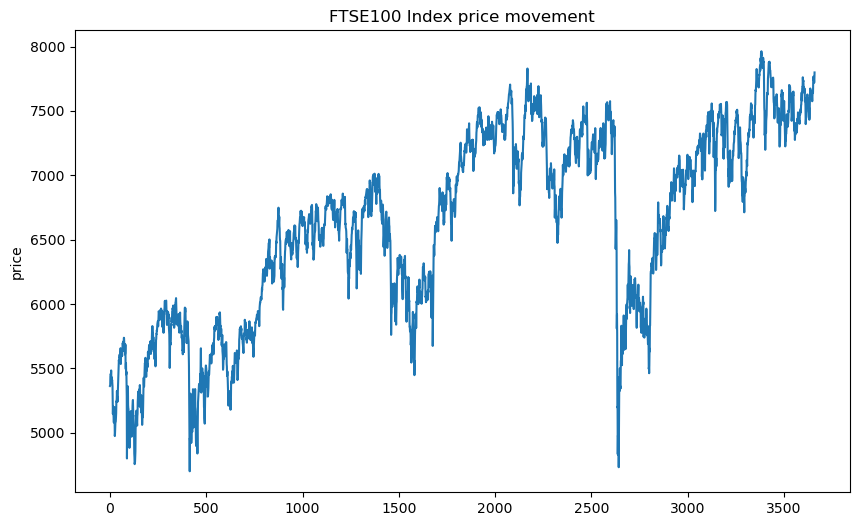

In [10]:
# Plot time series
plt.figure(figsize=(10, 6))
close_price.plot(title="FTSE100 Index price movement")
plt.ylabel("price")
plt.show()

Volatility: The jagged line indicates frequent price fluctuations, suggesting a volatile market period.

Significant Drop: A sharp decline in price around the 2000 mark on the x-axis could imply a market correction or a reaction to a significant event.

Recovery Trend: Following the drop, the price recovers and trends upward, indicating market resilience or positive investor sentiment.

In [11]:
# Function to calculate moving averages
def calculate_moving_average(data, period):
    return data.rolling(window=period).mean()

# Function to calculate Bollinger Bands
def calculate_bollinger_bands(data, period):
    sma = calculate_moving_average(data, period)
    std = data.rolling(window=period).std()
    upper_band = sma + (std * 2)
    lower_band = sma - (std * 2)
    return upper_band, lower_band

In [12]:
# Feature Engineering
data['SMA_50'] = calculate_moving_average(close_price, 50)
data['SMA_10'] = calculate_moving_average(close_price, 10)
data['Upper_Band'], data['Lower_Band'] = calculate_bollinger_bands(close_price, 200)
data.head(10)

,Date,Open,High,Low,Close,SMA_50,SMA_10,Upper_Band,Lower_Band
0,2010-01-01,5363.3,5363.3,5363.3,5363.3,NaN,NaN,NaN,NaN
1,2010-04-01,5456.5,5369.0,5467.0,5365.0,NaN,NaN,NaN,NaN
2,2010-05-01,5477.0,5451.5,5495.0,5438.5,NaN,NaN,NaN,NaN
3,2010-06-01,5485.5,5488.0,5495.5,5456.5,NaN,NaN,NaN,NaN
4,2010-07-01,5489.0,5474.5,5510.0,5456.5,NaN,NaN,NaN,NaN
5,2010-08-01,5490.0,5492.0,5507.0,5451.0,NaN,NaN,NaN,NaN
6,2010-11-01,5488.5,5520.5,5559.5,5484.5,NaN,NaN,NaN,NaN
7,2010-12-01,5456.0,5497.5,5506.5,5416.5,NaN,NaN,NaN,NaN
8,2010-01-13,5432.5,5433.0,5475.0,5407.5,NaN,NaN,NaN,NaN
9,2010-01-14,5452.0,5469.5,5478.0,5431.5,NaN,5427.08,NaN,NaN


In [13]:
data.dropna(inplace=True)
# Prepare your feature matrix X and target vector y
X = data[['SMA_50', 'SMA_10', 'Upper_Band', 'Lower_Band']].values
y = data['Close '].values

# Split the data
X_train, X_test, y_train, y_test = X[:-120], X[-120:], y[:-120],y[-120:] 

In [14]:
# RandomForest Model
rf_model = RandomForestRegressor(n_estimators=300, random_state=42)
rf_model.fit(X_train, y_train)

# XGBoost Model
xgb_model = XGBRegressor(n_estimators=300, random_state=42)
xgb_model.fit(X_train, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=300, n_jobs=None,
             num_parallel_tree=None, random_state=42, ...)

In [15]:
# Make predictions and evaluate
y_pred_rf = rf_model.predict(X_test)
y_pred_xgb = xgb_model.predict(X_test)

In [16]:
def create_dataset(data, window_size, forecast_step):
  # Create sequences and labels
  X, y = [], []
  for i in range(len(data) - window_size - forecast_step + 1):
    window = data[i:(i + window_size)]
    label = data[i + window_size + forecast_step - 1][0]  # Closing price after forecast step
    X.append(window)
    y.append(label)
  return np.array(X), np.array(y)

In [17]:
# Select relevant features
data_with_indicators = data[['Close ', 'SMA_50', 'SMA_10', 'Upper_Band', 'Lower_Band']]
data_no_indicators = data[['Close ']]
# Normalize data
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(data_with_indicators)
scaled_data_1 = scaler.fit_transform(data_no_indicators)

In [18]:
# Define window size and forecast step
window_size = 60  # Number of past days to consider
forecast_step = 1  # Predict closing price 1 day ahead

# Create sequences and labels
X, y = create_dataset(scaled_data, window_size, forecast_step)
X_1, y_1 = create_dataset(scaled_data_1, window_size, forecast_step)

In [19]:
# Split data into training, validation, and testing sets (adjust ratios as needed)

X_train, X_test, Y_train, Y_test = X[:-120], X[-120:], y[:-120],y[-120:] 
X_train_1, X_test_1, Y_train_1, Y_test_1 = X_1[:-120], X_1[-120:], y_1[:-120],y_1[-120:] 

In [20]:
def train_model(X_train, X_test, Y_train, Y_test, n):
    # Build LSTM model
    model = Sequential()
    model.add(LSTM(units=50, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])))
    model.add(Dropout(0.2))
    model.add(LSTM(units=50))
    model.add(Dropout(0.2))
    model.add(Dense(units=1))
    # Compile model
    model.compile(loss='mse', optimizer='adam')

    # Train model
    model.fit(X_train, Y_train, epochs= n, validation_data=(X_test, Y_test))
    return model

In [21]:
def evaluate_predictions(model, X_test, y_test, scaler):
    # Make predictions on test data
    predictions = model.predict(X_test)

    # Fit the scaler on training data
    scaler.fit(y_test.reshape(-1, 1))
    
    # Inverse transform the predictions and actual values
    predictions = scaler.inverse_transform(predictions)
    y_test_actual = scaler.inverse_transform(y_test.reshape(-1, 1))

    # Calculate Mean Squared Error (MSE)
    mse = np.mean((predictions - y_test_actual) ** 2)
    
    return predictions, y_test_actual, mse

In [25]:
def plot_predictions(predictions, actual_values):
    plt.figure(figsize=(10, 7.5))
    plt.plot(actual_values, label='Actual')
    plt.plot(predictions, label='Predicted')
    plt.title('Validation Dataset vs Predictions')
    plt.xlabel('Time')
    plt.ylabel('Value')
    plt.legend()
    plt.show()

In [26]:
model_base = train_model(X_train_1, X_test_1, Y_train_1, Y_test_1 , 20)

Epoch 1/20
103/103 [==============================] - 13s 63ms/step - loss: 0.0218 - val_loss: 0.0014
Epoch 2/20
103/103 [==============================] - 6s 54ms/step - loss: 0.0056 - val_loss: 0.0012
Epoch 3/20
103/103 [==============================] - 7s 69ms/step - loss: 0.0050 - val_loss: 0.0073
Epoch 4/20
103/103 [==============================] - 7s 71ms/step - loss: 0.0047 - val_loss: 0.0020
Epoch 5/20
103/103 [==============================] - 6s 60ms/step - loss: 0.0041 - val_loss: 0.0015
Epoch 6/20
103/103 [==============================] - 6s 58ms/step - loss: 0.0040 - val_loss: 6.8041e-04
Epoch 7/20
103/103 [==============================] - 6s 57ms/step - loss: 0.0038 - val_loss: 7.1459e-04
Epoch 8/20
103/103 [==============================] - 6s 57ms/step - loss: 0.0040 - val_loss: 0.0014
Epoch 9/20
103/103 [==============================] - 6s 54ms/step - loss: 0.0035 - val_loss: 6.7586e-04
Epoch 10/20
103/103 [==============================] - 7s 65ms/step - loss: 0.

In [27]:
model_with_indicators = train_model(X_train, X_test, Y_train, Y_test , 20)

Epoch 1/20
103/103 [==============================] - 15s 69ms/step - loss: 0.0419 - val_loss: 0.0016
Epoch 2/20
103/103 [==============================] - 5s 51ms/step - loss: 0.0084 - val_loss: 0.0026
Epoch 3/20
103/103 [==============================] - 5s 51ms/step - loss: 0.0069 - val_loss: 0.0013
Epoch 4/20
103/103 [==============================] - 5s 53ms/step - loss: 0.0060 - val_loss: 0.0014
Epoch 5/20
103/103 [==============================] - 7s 67ms/step - loss: 0.0056 - val_loss: 0.0017
Epoch 6/20
103/103 [==============================] - 7s 68ms/step - loss: 0.0052 - val_loss: 8.8744e-04
Epoch 7/20
103/103 [==============================] - 6s 54ms/step - loss: 0.0047 - val_loss: 9.5448e-04
Epoch 8/20
103/103 [==============================] - 6s 56ms/step - loss: 0.0045 - val_loss: 9.6869e-04
Epoch 9/20
103/103 [==============================] - 7s 64ms/step - loss: 0.0046 - val_loss: 9.5017e-04
Epoch 10/20
103/103 [==============================] - 7s 66ms/step - loss

In [37]:
# Evaluate model on testing data
lstm_loss_with_indicators = model_with_indicators.evaluate(X_test, Y_test)
lstm_loss_with_no_indicators = model_base.evaluate(X_test_1, Y_test_1)

4/4 [==============================] - 0s 21ms/step - loss: 0.0011


4/4 [==============================] - 0s 21ms/step


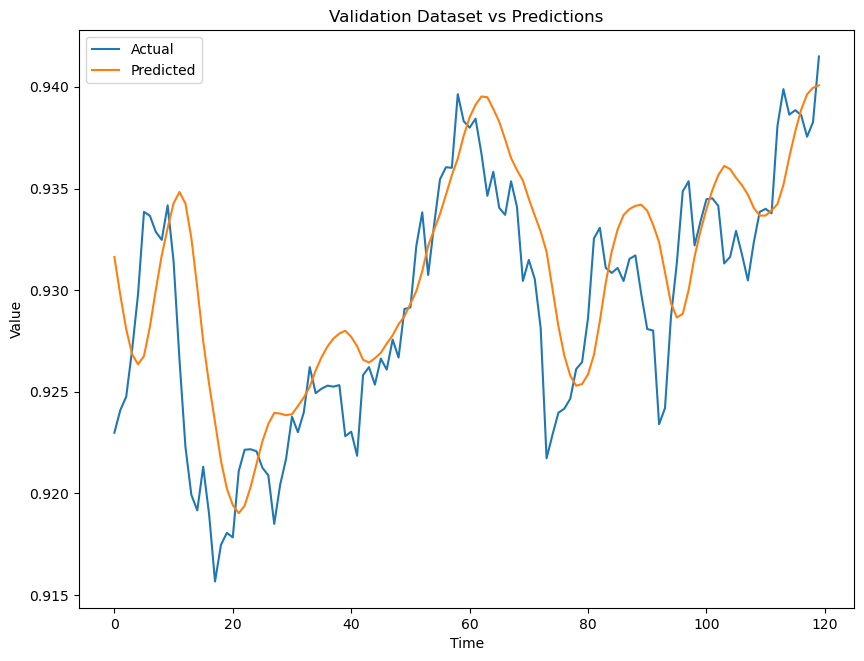

In [39]:
predictions, y_test_actual, mse = evaluate_predictions(model_with_indicators, X_test, Y_test, scaler)
plot_predictions(predictions, y_test_actual)

4/4 [==============================] - 0s 22ms/step


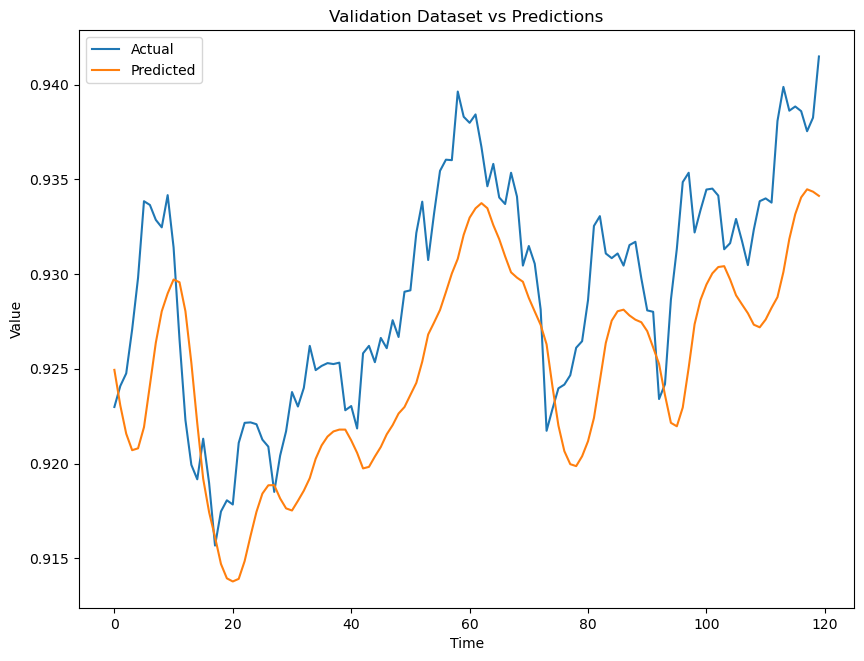

In [45]:
predictions_1, y_test_actual_1, mse_1 = evaluate_predictions(model_base, X_test_1, Y_test_1, scaler)
plot_predictions(predictions_1, y_test_actual_1)

In [41]:
# print('GRU MSE:', mean_squared_error(y_test, y_pred_gru))
print('RandomForest MSE:', mean_squared_error(y_test, y_pred_rf))
print('XGBoost MSE:', mean_squared_error(y_test, y_pred_xgb))
print('Lstm (with indicators) MSE:', lstm_loss_with_indicators)
print('Lstm (with no indicators) MSE:', lstm_loss_with_no_indicators)

RandomForest MSE: 10265.4485597926
XGBoost MSE: 16220.52071881461
Lstm (with indicators) MSE: 0.000620173872448504
Lstm (with no indicators) MSE: 0.001081510679796338
